# Example of preparing 2 image inputs for comparitive analysis 
1. Viewing input projections
2. warping input arrays to common grid
3. getting the common masked data (the union of each mask)
4. applying the common mask to the warped arrays  

In [3]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas
import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LinearSegmentedColormap000
#from matplotlib.colors import Normalize


import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

In [ ]:
import folium
import plotnine

## Change os.path.append() to your personal repo location

In [ ]:
import sys
sys.path.append('/att/gpfsfs/home/pmontesa/code/pygeotools')

In [ ]:
print(sys.path)

['/gpfsm/ccds01/home/pmontesa/code/geoscitools', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python37.zip', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/lib-dynload', '', '/home/pmontesa/.local/lib/python3.7/site-packages', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/jupyter_ilab-0.0.1-py3.7.egg', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/nodejs-0.1.1-py3.7.egg', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/optional_django-0.1.0-py3.7.egg', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/ipython_genutils-0.2.0-py3.7.egg', '/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/webencodings-0.5.1-py3.7.egg', '/gpfsm/ccds01/home

In [ ]:
from pygeotools.lib import iolib, malib, geolib, filtlib, warplib

In [ ]:
import osgeo
from osgeo import gdal, ogr, osr
print(osgeo.gdal.VersionInfo())

3030200


#### Functions

In [ ]:
def plot_maps(masked_array_list, names_list, figsize=None, cmap_list=None, clim_list=None, title_text=""):
    
    if figsize is None:
        figsize = (len(names_list) * 7,5)
    
    fig, axa = plt.subplots( nrows=1, ncols=len(masked_array_list), figsize=figsize, sharex=False, sharey=False)

    for i, ma in enumerate(masked_array_list):
        
        if cmap_list is None:
            cmap = 'RdYlGn'
        else:
            cmap = cmap_list[i]
            
        if clim_list is None:
            clim = malib.calcperc(ma, perc=(1,95))
        else:
            clim = clim_list[i]

        f_name = names_list[i]
        
        divider = make_axes_locatable(axa[i])
        cax = divider.append_axes('right', size='2.5%', pad=0.05)
        im1 = axa[i].imshow(ma, cmap=cmap , clim=clim )
        cb = fig.colorbar(im1, cax=cax, orientation='vertical', extend='max')
        axa[i].set_title(title_text + os.path.split(f_name)[1], fontsize=10)
        cb.set_label('Reflectance (%)')

        plt.tight_layout() 

def plot_hists(masked_array_list, names_list, figsize=None, title_text=""):
    
    if figsize is None:
        figsize = (len(names_list) * 7,5)
    
    fig, axa = plt.subplots(nrows=1, ncols=len(masked_array_list), figsize=figsize, sharex=False, sharey=False)

    for i, ma in enumerate(masked_array_list):
        f_name = names_list[i]
        print(f" {ma.count()} valid pixels in INPUT MASKED ARRAY version of {f_name}")

        h = axa[i].hist(ma.compressed(), bins=256, alpha=0.75)
        axa[i].set_title(title_text + os.path.split(f_name)[1], fontsize=10)

    plt.tight_layout() 

#### Play with CCDC and ARD as inputs - ignore for now

##### Adding Landsat ARD data
* Reproject select Landsat ARD of interest to corresponding CCDC

In [ ]:

if False:
    %matplotlib inline
    plt.rcParams.update({'font.size': 14})

    # all names come off of WV name
    WV_FN_LIST = ["WV02_20150616_M1BS_103001004351F000",\
                  "WV02_20110818_M1BS_103001000CCC9000",\
                  "WV03_20180529_M1BS_104001003D032200"]
    # Get Landsat ARD - need better way - try footprint then intersect with bounds of WV_FN to find data...
    LARD_FN_LIST = ["/adapt/nobackup/projects/ilab/data/LandSatABoVE/62N/164W_62N/815.tif",\
                   "/adapt/nobackup/projects/ilab/data/LandSatABoVE/62N/163W_62N/726.tif",\
                   "/adapt/nobackup/projects/ilab/data/LandSatABoVE/64N/147W_64N/884.tif"]
    # Output warped Landsat ARD
    DIR_OUT_ARD = '/adapt/nobackup/people/iluser/projects/srlite/input/LandSatABoVE_WARP'

    DO_PLOTS = False

    os.makedirs(DIR_OUT_ARD, exist_ok=True)

    for i, WV_FN in enumerate(WV_FN_LIST):

        EVHR_TOA_FN = f"/adapt/nobackup/people/iluser/projects/srlite/input/TOA_v2/Yukon_Delta/5-toas/{WV_FN}-toa.tif"
        CCDC_FN     = f"/adapt/nobackup/people/iluser/projects/srlite/input/CCDC_v2/{WV_FN}-ccdc.tif"    
        LARD_FN     = LARD_FN_LIST[i]
        OUT_LANDSAT_ARD_FN = os.path.join(DIR_OUT_ARD, WV_FN+'-landsatARD-warp.tif')

        with rasterio.open(CCDC_FN, "r") as ccdc_dataset:
            out_meta = ccdc_dataset.meta.copy()
            n_bands = ccdc_dataset.count
            ccdc_dataset_profile = ccdc_dataset.profile
        print(f"# of CCDC bands: {n_bands}")
        print(ccdc_dataset_profile)

        with rasterio.open(LARD_FN, "r") as lard_dataset:
            n_bands_lard = lard_dataset.count
            lard_dataset_profile = lard_dataset.profile
        print(f"# of LARD bands: {n_bands_lard}")
        print(lard_dataset_profile)

        out_meta.update({
                            "dtype": lard_dataset_profile['dtype'],
                            "nodata": None
                        })
        print(out_meta)

        # Get input and plot
        fn_list =  [CCDC_FN, LARD_FN]
        band_list = []

        for bandnum in range(1, n_bands_lard+1):

            print(f"\nBand #{bandnum}")
            ma_list = [iolib.fn_getma(fn, bnum=bandnum) for fn in fn_list]
            if DO_PLOTS:
                figsize=(10,5)
                plot_maps(ma_list, fn_list, figsize, title_text=f"Input Band {bandnum}\n")

            # Warp LARD to CCDC
            warp_ds_list = warplib.memwarp_multi_fn(fn_list, res='first', extent='first', t_srs='first', r='cubic')
            warp_ma_list = [iolib.ds_getma(ds, bnum=bandnum) for ds in warp_ds_list]

            if DO_PLOTS:
                plot_maps(warp_ma_list, fn_list, figsize,title_text=f"Warped Band {bandnum}\n")

            # Output warped Landsat ARD (the second item) based on ds of ccdc (first item)
            ccdc_ds = warp_ds_list[0]

            landsat_ard_ma = warp_ma_list[1]

            # This write out a single band
            #iolib.writeGTiff(landsat_ard_ma, OUT_LANDSAT_ARD_FN, src_ds=ccdc_ds)

            band_list.append(landsat_ard_ma)
        print(f"\nWriting all bands to: {OUT_LANDSAT_ARD_FN}")
        with rasterio.open(OUT_LANDSAT_ARD_FN, 'w', **out_meta) as dest:
            for band, src in enumerate(band_list, start=1):
                dest.write(src, band)

# Set up inputs

In [ ]:
#maindir = '/att/nobackup/gtamkin/srlite/pitkus-point-demo'
#r_fn_evhr = os.path.join(maindir, 'EVHR-WV02_20110818_M1BS_103001000CCC9000-toa.tif')
#r_fn_ccdc = os.path.join(maindir, 'GEE-CCDC-pitkusPointSubset-esri102001-30m.tif')
#r_fn_ccdc = os.path.join(maindir, 'GEE-CCDC-PitkusPointSubset-epsg4326-30m.tif')

#maindir = '/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/12-21-2021'
maindir = '/adapt/nobackup/projects/ilab/data/srlite'

# Old inputs
#r_fn_ccdc = os.path.join(maindir, 'ccdc_20110818.tif')
#r_fn_evhr = os.path.join(maindir, 'WV02_20110818_M1BS_103001000CCC9000-toa-pitkusPoint-cog.tif')

# New inputs
r_fn_ccdc = os.path.join(maindir, 'ccdc/CCDC_ALL/WV02_20180527_M1BS_103001007E5F8400-ccdc.tif')
r_fn_evhr = os.path.join(maindir, 'toa/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.tif')
r_fn_cloud = os.path.join(maindir, 'cloudmask/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.cloudmask.v1.2.tif')

fn_list = [r_fn_ccdc, r_fn_evhr, r_fn_cloud]

OUTDIR = '/adapt/nobackup/people/pmontesa/userfs02/projects/srlite/misc'

#!source activate ilab-kernel; python /att/gpfsfs/home/pmontesa/code/evhr/utm_proj_select.py ${r_fn_hrsi}

# This wont run here until osgeo import gets sorted out
#os.system('python /att/gpfsfs/home/pmontesa/code/evhr/utm_proj_select.py '+ os.path.join(maindir,r_fn_hrsi))


#### Look at the CCDC projection (2 ways)

In [13]:
print(r_fn_ccdc)
ccdc_ds = iolib.fn_getds(r_fn_ccdc)
print(ccdc_ds.GetProjection())
!gdalinfo /att/nobackup/pmontesa/userfs02/projects/srlite/12-21-2021/ccdc_20110818.tif

/adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL/WV02_20180527_M1BS_103001007E5F8400-ccdc.tif
PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]
/usr/local/bin/bash: gdalinfo: command not found


#### Look at the EVHR projection (2 ways)

In [14]:
evhr_ds = iolib.fn_getds(r_fn_evhr)
print(evhr_ds.GetProjection())
!gdalinfo '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/projects/srlite/12-21-2021/WV02_20110818_M1BS_103001000CCC9000-toa-pitkusPoint-cog.tif'

PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]
/usr/local/bin/bash: gdalinfo: command not found


### Check the nodata values of each file

In [15]:
import rasterio
def get_ndv(r_fn):
    with rasterio.open(r_fn) as src:
        return src.profile['nodata']
    
ndv_list = [get_ndv(fn) for fn in fn_list]
ndv_list

[-9999.0, -9999.0, -9999.0]

### Get the input arrays

In [ ]:
ma_list = [iolib.fn_getma(fn) for fn in fn_list]

### Examine input arrays
maps

In [125]:
# These could be large (orig 2m res)
if False:
    plot_maps(ma_list, fn_list, figsize)

histograms

 2593565 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL/WV02_20180527_M1BS_103001007E5F8400-ccdc.tif
 531648506 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/toa/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.tif
 531648506 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/cloudmask/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.cloudmask.v1.2.tif


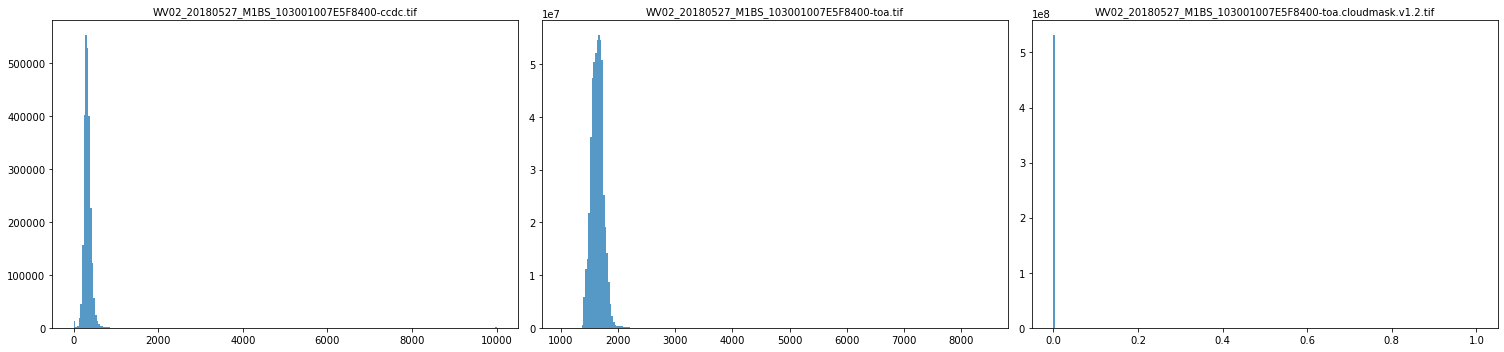

In [107]:
plot_hists(ma_list, fn_list, figsize=None)

In [146]:
[ma.get_fill_value() for ma in ma_list]

[-9999, -9999, -9999.0]

## Warp the input data for stacking
to stack these images into a common grid (with an extent, projection, and resolution chosen from the input), use warplib  


##### Notes on warping:
 - We are using the convenient gdalwarp wrapper functions here:  
 https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/warplib.py
 - 'average' resampling could be best for downscaling
 - The ccdc 'extent' instead of 'intersection' will prevent a sub-pixel shift in the returned warped version of the ccdc - providing most certain adherence to the original ccdc pixels.
 - But - we want the extent to be determined by the evhr toa  
     - So --> `extent=r_fn_evhr`
 - For now, we can set the target srs to that of the evhr toa
      - So --> `t_srs=r_fn_evhr`
 
 - We want the toa to be downscaled in a way that preserves the range of the toa values (so, NOT 'near')  
 - We also want categorical arrays (cloudmask) to remain as such.  
     - So --> `r = 'mode'` , b/c resampling with 'mode' will satisfy  both these requirements 
 - We want the output res to be that of the reference dataset
      - So --> `res=r_fn_ccdc`

##### Notes on nodata:
 - Incoming nodata values can be determined using rasterio (shown above in this notebook)  
 - During the warp, if an output nodata value is not set, then the input nodata value is used (supposedly!):   https://github.com/dshean/pygeotools/blob/e780b4ced1c9fda19d20ba6c41839d9ffa1247d3/pygeotools/lib/warplib.py#L150
 - HOWEVER (CRITICAL WEIRDNESS ALERT) we noticed when examining the arrays in the list of warped masked arrays (warp_ma_list):
      - if `dst_ndv` is NOT set, then AFTER the warp this nodata value isnt preserved and instead is set to 0:  
      `warp_ma_list[2]` -->  we see the fill value = 0 (expected -9999.0)
 - Therefore, since all the incoming files have nodata=-9999, we explicity set the destination nodata value to one of them (here, we use that of the incoming toa)
 - So --> `dst_ndv=get_ndv(r_fn_evhr)`


In [147]:
# This give the same result as ma.get_fill_value(), but you dont need to have read the data in - so its more useful for setting the dst_ndv in the warp command below
get_ndv(r_fn_evhr)

-9999.0

In [132]:
# ---Doing the warp ---

# Here, the warped datasets and their arrays in these lists will be in the same order as your initial filenames list (fn_list)
warp_ds_list = warplib.memwarp_multi_fn(fn_list, res=r_fn_ccdc, extent=r_fn_evhr, t_srs=r_fn_evhr, r='mode', dst_ndv=get_ndv(r_fn_evhr))


Warping all inputs to the following:
Resolution: 30.0
Extent: [386637.0, 7207141.0, 410133.0, 7324025.0]
Projection: '+proj=utm +zone=6 +datum=WGS84 +units=m +no_defs'
Resampling alg: mode

1 of 3: /adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL/WV02_20180527_M1BS_103001007E5F8400-ccdc.tif
nl: 3896 ns: 783 res: 30.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 3: /adapt/nobackup/projects/ilab/data/srlite/toa/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.tif
nl: 3896 ns: 783 res: 30.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 3: /adapt/nobackup/projects/ilab/data/srlite/cloudmask/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.cloudmask.v1.2.tif
nl: 3896 ns: 783 res: 30.000
100 - done.
0...10...20...30...40...50...60...70...80...90...
All these arrays should now have the same shape:

(3896, 783)
(3896, 783)
(3896, 783)


[None, None, None]

### Get the warped arrays from the warped datasets

In [139]:
# I know the order of my filenames list, so I can name the output arrays like this
# If the order of the fn_list changes, then these warp_ma variable names wont be correctly describing the data

ccdc_warp_ma, evhr_warp_ma, cloudmask_warp_ma = [iolib.ds_getma(ds) for ds in warp_ds_list]

### Mask out cloud values in the cloudmask warped masked array

In [149]:
# Mask out cloudmask=1 values, which are the values for cloud features

warp_ma_list = [ccdc_warp_ma, evhr_warp_ma, np.ma.masked_where(cloudmask_warp_ma == 1.0, cloudmask_warp_ma)]

print('\nAll these arrays should now have the same shape:\n')
[print(ma.shape) for ma in warp_ma_list]


All these arrays should now have the same shape:

(3896, 783)
(3896, 783)
(3896, 783)


[None, None, None]

### Check the valid range of each array
Note, after the warp (with 'near' resampling), the 0 values disappear - and mins change to 1

In [148]:
[warp_ma.get_fill_value() for warp_ma in warp_ma_list]

[-9999, -9999, -9999.0]

In [150]:
print('Input array mins/maxs')
[print(f'input ma min: {ma.min()}') for ma in ma_list]
[print(f'input ma max: {ma.max()}') for ma in ma_list]
print('Warped array mins/maxs')
[print(f'warped ma min: {ma.min()}') for ma in warp_ma_list]
[print(f'warped ma max: {ma.max()}') for ma in warp_ma_list]

Input array mins/maxs
input ma min: 0
input ma min: 1051
input ma min: 0.0
input ma max: 10000
input ma max: 8440
input ma max: 1.0
Warped array mins/maxs
warped ma min: 0
warped ma min: 1377
warped ma min: 0.0
warped ma max: 10000
warped ma max: 7976
warped ma max: 0.0


[None, None, None]

### Warped masked arrays
maps & histograms

 2649413 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL/WV02_20180527_M1BS_103001007E5F8400-ccdc.tif
 2367184 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/toa/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.tif
 2367131 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/cloudmask/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.cloudmask.v1.2.tif


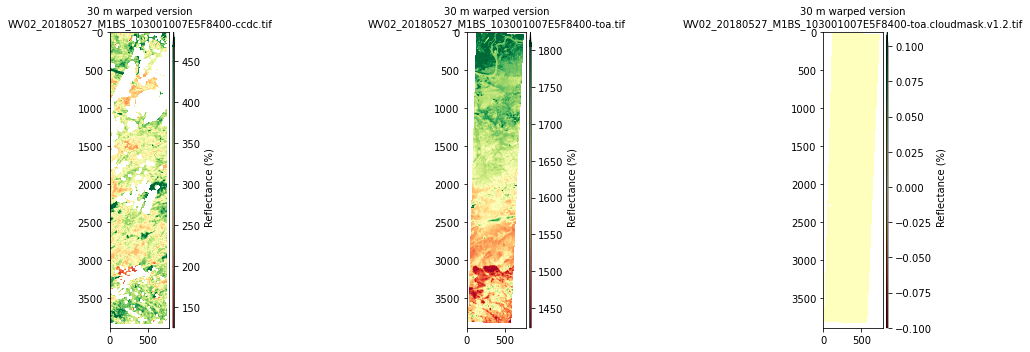

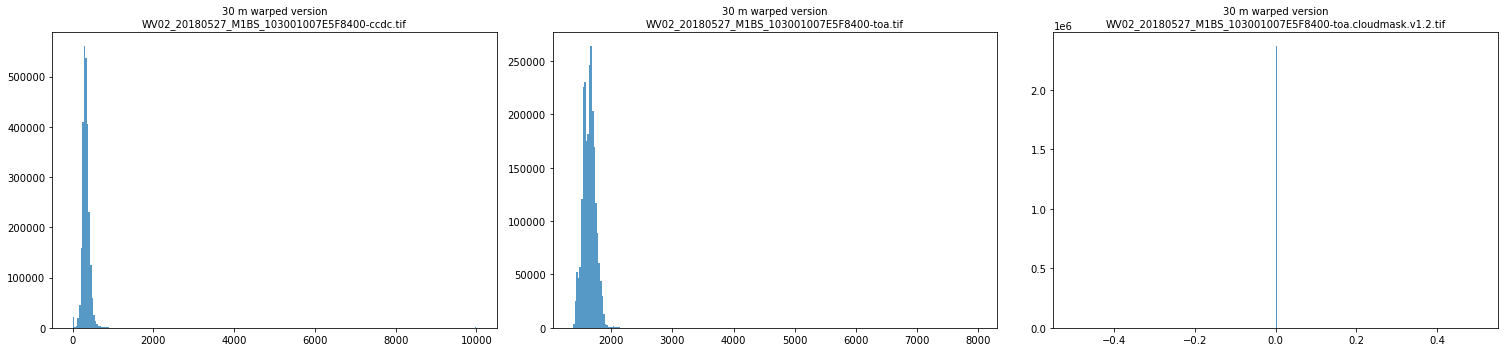

In [154]:
plot_maps(warp_ma_list, fn_list, title_text = '30 m warped version\n') 
plot_hists(warp_ma_list, fn_list, title_text = '30 m warped version\n')

### Get a common mask of valid data from the inputs

In [155]:
# Mask negative values in input
warp_valid_ma_list = [ np.ma.masked_where(ma < 0, ma) for ma in warp_ma_list]

common_mask = malib.common_mask(warp_valid_ma_list)
common_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

### Warped masked arays with common mask applied
now, each input should have same exact dimensions, grid, projection. They ony differ in their values (CCDC is surface reflectance, EVHR is TOA reflectance)  
maps and histograms

 2143677 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/ccdc/CCDC_ALL/WV02_20180527_M1BS_103001007E5F8400-ccdc.tif
 2143677 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/toa/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.tif
 2143677 valid pixels in INPUT MASKED ARRAY version of /adapt/nobackup/projects/ilab/data/srlite/cloudmask/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.cloudmask.v1.2.tif


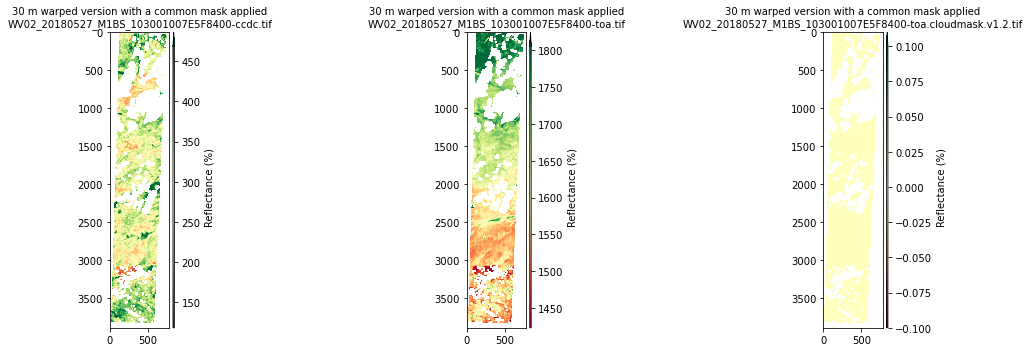

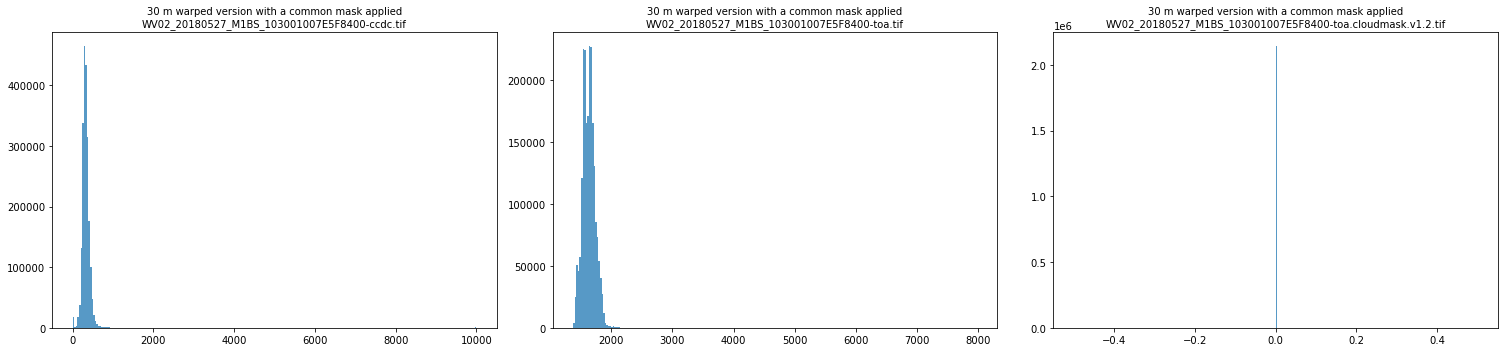

In [159]:
warp_ma_masked_list = [np.ma.array(ma, mask=common_mask) for ma in warp_ma_list]

plot_maps(warp_ma_masked_list, fn_list, title_text='30 m warped version with a common mask applied\n')
plot_hists(warp_ma_masked_list, fn_list, title_text='30 m warped version with a common mask applied\n')

# Comparative Analysis
https://realpython.com/linear-regression-in-python/#simple-linear-regression-with-scikit-learn

https://stackoverflow.com/questions/64581875/how-to-run-linear-regression-of-a-masked-array

https://stackoverflow.com/questions/21447595/how-to-mask-clouds-from-python-numpy-array-for-a-linear-regression-model

We've used the cloudmask to mask out pixels of toa clouds that we dont want to continate the model  
It has served its purpose, and we can remove it from our list

In [162]:
warp_ma_masked_list = warp_ma_masked_list[0:2]

In [163]:
# Check the mins of each ma - they should be greater than 0
for i, ma in enumerate(warp_ma_masked_list):
    f_name = os.path.basename(fn_list[i])
    print(f'Min TOA value: {ma.min()} ({f_name})')


Min TOA value: 0 (WV02_20180527_M1BS_103001007E5F8400-ccdc.tif)
Min TOA value: 1377 (WV02_20180527_M1BS_103001007E5F8400-toa.tif)


#### Prep the x and y data

In [164]:
# CCDC SR is first element in list, which needs to be the y-var: b/c we are predicting SR from TOA
y_var, x_var = [ma.ravel() for ma in warp_ma_masked_list]

y_var = y_var[y_var.mask == False]
x_var = x_var[x_var.mask == False]

#### Scatterplot (binned)

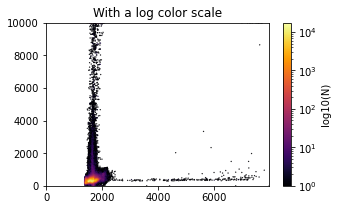

In [169]:
figsize=(5,3)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, sharex=True, sharey=True)

hb = ax.hexbin(x_var.ravel().data, y_var.ravel().data, gridsize=500, bins='log', cmap='inferno')
ax.axis([0, x_var.max(), 0, y_var.max()])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

#### Run the linear model

Model coefs: [[0.34257365]], [-220.12720807]
Check the mins of the input and output...
Check input TOA min:  1377
Check output prediction of SR for the input TOA min:  [[251.59670923]]
intercept: [-220.12720807]
slope: [[0.34257365]]


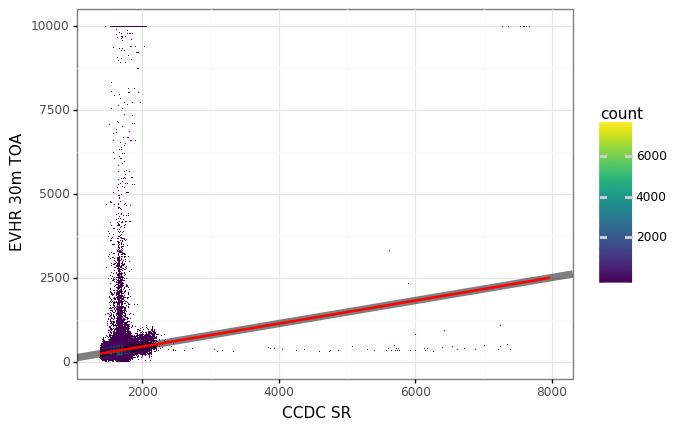

<ggplot: (2957457174013)>

In [167]:
model = LinearRegression().fit(x_var.reshape(-1,1), y_var.reshape(-1,1))
print(f'Model coefs: {model.coef_}, {model.intercept_}')

print('Check the mins of the input and output...')
input_min = warp_ma_masked_list[1].reshape(-1,1).min()
print("Check input TOA min: ", input_min)
print("Check output prediction of SR for the input TOA min: ", model.predict(input_min.reshape(-1,1)))


print('intercept:', model.intercept_)
print('slope:', model.coef_)
#print('score:', model.score(y_var, x_var ))

from plotnine import ggplot, aes, geom_line, geom_point, geom_smooth, geom_bin2d, geom_abline, xlim, ylim, labs, theme_minimal, theme_bw

(
    ggplot()  # What data to use
    + aes(x=x_var, y=y_var)  # What variable to use
    + geom_bin2d(binwidth=10)  # Geometric object to use for drawing
    + geom_abline(slope = model.coef_[0], intercept = model.intercept_, size=3, alpha = 0.5)
    + geom_smooth(method = 'lm', color='red')
    + labs(x='CCDC SR', y='EVHR 30m TOA')
    + theme_bw()
    # + xlim(0,500) + ylim(0,500)

)

#### Apply the model to the original EVHR (2m) to predict surface reflectance
be careful - make sure `ma_list[1]` in fact is the original masked array of the evhr toa

In [168]:
print(f'Applying model to {os.path.basename(fn_list[1])}')
print(f'Input masked array shape: {ma_list[1].shape}')

sr_prediction = model.predict(ma_list[1].ravel().reshape(-1,1))
print(f'Post-prediction shape: {sr_prediction.shape}')

# Return to original shape and apply original mask
orig_dims = ma_list[1].shape
evhr_sr_ma = np.ma.array(sr_prediction.reshape(orig_dims), mask=ma_list[1].mask)

# Check resulting ma
print(f'Final masked array shape: {evhr_sr_ma.shape}')
evhr_sr_ma

Applying model to WV02_20180527_M1BS_103001007E5F8400-toa.tif
Input masked array shape: (58442, 11748)
Post-prediction shape: (686576616, 1)
Final masked array shape: (58442, 11748)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

#### Compare the before and after histograms (EVHR TOA vs EVHR SR)

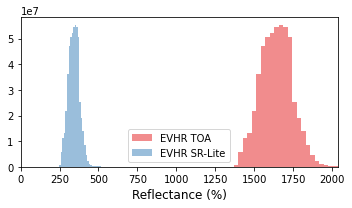

In [173]:
evhr_pre_post_ma_list = [ma_list[1], evhr_sr_ma]
compare_name_list = ['EVHR TOA', 'EVHR SR-Lite']

figsize=(5,3)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, sharex=True, sharey=True)
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

for i, ma in enumerate(evhr_pre_post_ma_list):
    f_name = compare_name_list[i]
       
    h = ax.hist(ma.compressed(), bins=256, alpha=0.5, label=f_name, color=colors[i] )
    ax.legend()
    ax.set_xlim((0, max([ma.mean()+3*ma.std() for ma in evhr_pre_post_ma_list])))
    ax.set_xlabel('Reflectance (%)', fontsize=12)
    
plt.tight_layout()  

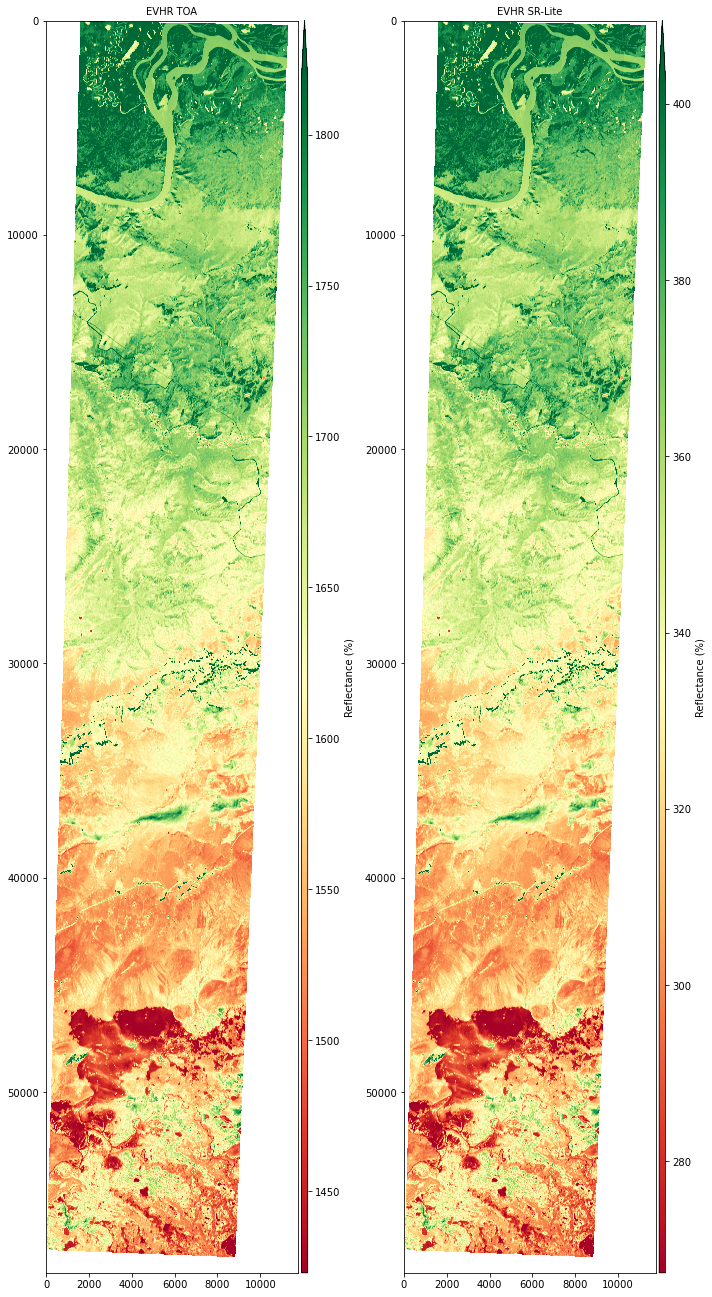

In [174]:
plot_maps(evhr_pre_post_ma_list, compare_name_list, (10,50))

In [187]:
diff_ma = evhr_pre_post_ma_list[1]-evhr_pre_post_ma_list[0]

plot_maps([diff_ma], ['Difference: TOA-SR-Lite'], (10,50), 
          cmap_list=['Reds'], 
          #clim_list=[ malib.calcperc(diff_ma, perc=(1,95)) ] 
         )

MemoryError: Unable to allocate 5.12 GiB for an array with shape (58442, 11748) and data type float64